# Кросс-валидация, перебор гиперпараметров и сериализация моделей

В этом ноутбуке мы разберём три важных практических темы, которые связывают воедино все классические модели машинного обучения:

- **кросс-валидация** (cross-validation) для более надёжной оценки качества;
- **перебор гиперпараметров** (hyperparameter tuning) с помощью кросс-валидации;
- **сериализация моделей** (сохранение в файл и загрузка) для дальнейшего использования.

План ноутбука:

1. Почему простого train/test split недостаточно.
2. Кросс-валидация: идея, схемы, `cross_val_score` и друзья.
3. Другие схемы кросс-валидации (стратификация, временные ряды).
4. Перебор гиперпараметров как оптимизация по сетке значений.
5. `GridSearchCV`: полный перебор по сетке.
6. `RandomizedSearchCV`: случайный поиск по пространству гиперпараметров.
7. Вложенная кросс-валидация (nested cross-validation) и честная оценка.
8. Идея байесовской оптимизации и Optuna (на уровне концепции и примера кода).
9. Сериализация моделей: `joblib.dump` и `joblib.load`, сохранение пайплайнов.
10. Итоги и практические рекомендации.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    TimeSeriesSplit,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

import joblib

np.random.seed(42)

In [2]:
def plot_decision_boundary(clf, X, y, title="", h=0.02):
    """Рисует границу принятия решения для двумерных данных."""
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(["#FFEEEE", "#EEEEFF", "#EEFFEE"])
    cmap_bold = ListedColormap(["#FF0000", "#0000FF", "#00AA00"])

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.6, cmap=cmap_light)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=40)

    plt.title(title)
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.show()

## 1. Почему простого train/test split недостаточно

Обычный базовый подход к оценке качества модели:

1. Разбить выборку на обучающую и тестовую: $D = D_{\text{train}} \cup D_{\text{test}}$.
2. Обучить модель на $D_{\text{train}}$.
3. Оценить качество (например, accuracy) на $D_{\text{test}}$.

Формально, тестовая метрика $\hat{Q}$ — это оценка **обобщающей способности** модели на новых данных. Например, для accuracy:

$$
\hat{Q} = \frac{1}{|D_{\text{test}}|} \sum_{(x_i, y_i) \in D_{\text{test}}} [\hat{y}(x_i) = y_i].
$$

Проблемы такого подхода:

- результат **зависит от конкретного случайного разбиения**;
- при небольшом размере выборки оценка может иметь большую дисперсию;
- если мы много раз меняем модель и гиперпараметры, подсматривая на тест, мы **подстраиваемся под тест**, и метрика перестаёт быть честной.

Кросс-валидация как раз и помогает:

- уменьшить зависимость от конкретного разбиения;
- более эффективно использовать данные;
- корректно использовать тестовый набор только в самом конце.


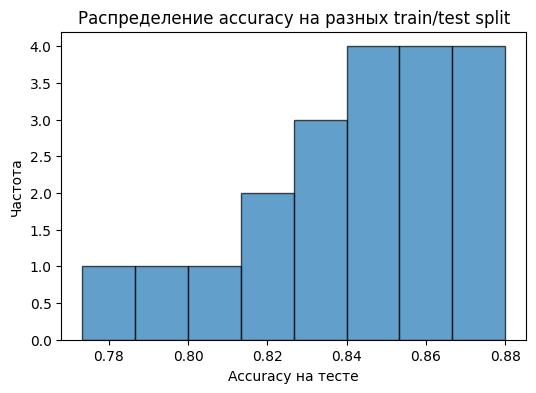

Средний accuracy по разбиениям: 0.8393333333333335
Стандартное отклонение accuracy: 0.02827641341393133


In [16]:
# Сгенерируем не очень большую выборку для классификации
X, y = make_classification(
    n_samples=500,
    n_features=10,
    n_informative=5,
    n_redundant=0,
    n_clusters_per_class=2,
    class_sep=1.0,
    random_state=42
)

clf = LogisticRegression(max_iter=1000)

# Посмотрим, как меняется accuracy при разных случайных разбиениях
test_scores = []
rng = np.random.RandomState(42)

for random_state in range(20):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state, stratify=y
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    test_scores.append(acc)

plt.figure(figsize=(6, 4))
plt.hist(test_scores, bins=8, edgecolor="k", alpha=0.7)
plt.title("Распределение accuracy на разных train/test split")
plt.xlabel("Accuracy на тесте")
plt.ylabel("Частота")
plt.show()

print("Средний accuracy по разбиениям:", np.mean(test_scores))
print("Стандартное отклонение accuracy:", np.std(test_scores))

На графике видно, что:

- разные случайные разбиения дают заметно разные значения accuracy;
- стандартное отклонение может быть вполне ощутимым.

Кросс-валидация предлагает более стабильный подход: мы многократно обучаем модель на разных подвыборках и усредняем качество.


## 2. Кросс-валидация: идея и базовые определения

Пусть есть выборка

$$
D = \{(x_i, y_i)\}_{i=1}^n.
$$

**K-fold кросс-валидация** (обычно говорят $K$-fold CV) работает так:

1. Разбиваем индексы объектов на $K$ примерно равных по размеру непересекающихся подмножеств (фолдов):

$$
F_1, F_2, \dots, F_K.
$$

2. Для каждого фолда $k$:

   - используем $F_k$ как валидационное множество,
   - все остальные фолды $\bigcup_{j \ne k} F_j$ используем как обучающее множество.

3. Для каждого фолда считаем метрику качества (например, $Q_k$).

Итоговая оценка качества:

$$
\hat{Q} = \frac{1}{K} \sum_{k=1}^K Q_k.
$$

Это даёт более устойчивую оценку, поскольку:

- каждый объект побывает и в обучении, и в валидации (ровно один раз);
- мы усредняем метрику по нескольким разбиениям.

В задачах классификации важно также сохранять долю классов в каждом фолде. Для этого используют **стратифицированную кросс-валидацию** (стратифицированные фолды).


### 2.1. Пример: StratifiedKFold и `cross_val_score`

Посмотрим на простом примере с логистической регрессией, как выглядит кросс-валидация в `scikit-learn`.


In [4]:
X_small, y_small = make_classification(
    n_samples=200,
    n_features=10,
    n_informative=5,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.0,
    random_state=42
)

logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    logreg_pipeline,
    X_small,
    y_small,
    cv=cv,
    scoring="accuracy"
)

print("Оценки accuracy по фолдам:", scores)
print("Средний accuracy:", scores.mean())
print("Стандартное отклонение:", scores.std())

Оценки accuracy по фолдам: [0.95  0.925 1.    0.925 0.925]
Средний accuracy: 0.945
Стандартное отклонение: 0.029154759474226483


Функция `cross_val_score` автоматически:

- берёт модель (в нашем случае пайплайн с масштабированием признаков);
- разбивает данные на фолды по схеме, заданной в `cv`;
- для каждого фолда обучает модель и оценивает метрику;
- возвращает массив значений метрики по фолдам.

По этим значениям мы можем судить не только о среднем качестве, но и о разбросе (стабильности) модели.


### 2.2. `cross_validate` и `cross_val_predict`

Кроме `cross_val_score`, в `scikit-learn` есть полезные функции:

- `cross_validate` — возвращает не только метрики, но и времена обучения, а также может возвращать несколько метрик сразу;
- `cross_val_predict` — возвращает предсказания модели для **каждого объекта**, полученные в режиме кросс-валидации (то есть объект всегда предсказывается моделью, которая его не видела на обучении).

Краткий пример `cross_validate`:


In [5]:
results = cross_validate(
    logreg_pipeline,
    X_small,
    y_small,
    cv=cv,
    scoring=["accuracy", "f1"],
    return_train_score=True
)

print("Ключи результата:", results.keys())
print("Accuracy test по фолдам:", results["test_accuracy"])
print("F1 test по фолдам:", results["test_f1"])
print("Среднее время fit:", np.mean(results["fit_time"]))

Ключи результата: dict_keys(['fit_time', 'score_time', 'test_accuracy', 'train_accuracy', 'test_f1', 'train_f1'])
Accuracy test по фолдам: [0.95  0.925 1.    0.925 0.925]
F1 test по фолдам: [0.95       0.92682927 1.         0.92682927 0.93023256]
Среднее время fit: 0.003761482238769531


## 3. Другие схемы кросс-валидации

Кроме классического $K$-fold и его стратифицированного варианта, есть и другие схемы разбиений:

1. **StratifiedShuffleSplit** — много случайных разбиений на train/validation с сохранением долей классов.
2. **GroupKFold** — разбиение по группам (например, когда разные строки относятся к одному пользователю, мы хотим не "пересекать" пользователей между train и validation).
3. **Leave-One-Out (LOO)** — по сути $K$-fold с $K = n$, когда каждый объект по очереди становится валидационным (очень дорого, используется редко).
4. **TimeSeriesSplit** — для временных рядов, где нельзя перемешивать данные, а валидация должна идти "по времени вперёд".

Для временных рядов, например, нельзя просто перемешать данные: валидация должна имитировать предсказание будущего по прошлому.


### 3.1. Пример индексов для `TimeSeriesSplit`

Кратко посмотрим, как `TimeSeriesSplit` делит индексы.


In [6]:
tscv = TimeSeriesSplit(n_splits=4)

X_ts = np.arange(20).reshape(-1, 1)
y_ts = np.arange(20)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_ts, y_ts), 1):
    print(f"Фолд {fold}")
    print("  train индексы:", train_idx)
    print("  test индексы:", test_idx)
    print()

Фолд 1
  train индексы: [0 1 2 3]
  test индексы: [4 5 6 7]

Фолд 2
  train индексы: [0 1 2 3 4 5 6 7]
  test индексы: [ 8  9 10 11]

Фолд 3
  train индексы: [ 0  1  2  3  4  5  6  7  8  9 10 11]
  test индексы: [12 13 14 15]

Фолд 4
  train индексы: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
  test индексы: [16 17 18 19]



Видно, что обучающие индексы всегда "до" тестовых, и по мере продвижения фолдов обучающая часть увеличивается, а тестовая сдвигается вперёд по времени.


## 4. Перебор гиперпараметров и кросс-валидация

Пусть у модели есть набор гиперпараметров $h$ (например, глубина дерева, число деревьев в случайном лесу, $C$ и $\gamma$ в SVM). Обозначим пространство гиперпараметров через $\mathcal{H}$.

Задача перебора гиперпараметров: выбрать такие гиперпараметры $\hat{h}$, которые дают наилучшее качество по выбранной метрике на обучающих данных (обычно измеряемое с помощью кросс-валидации). Формально:

$$
\hat{h} = \arg\max_{h \in \mathcal{H}} \hat{Q}(h),
$$

где $\hat{Q}(h)$ — это, например, средний accuracy на кросс-валидации при гиперпараметрах $h$.

Важно:

- **нельзя** подбирать гиперпараметры, ориентируясь на тестовую выборку;
- тестовый набор должен быть отложен до самого конца и использоваться только один раз, для финальной оценки.


### 4.1. Общий алгоритм перебора по сетке (grid search)

Если мы задаём конечную сетку значений гиперпараметров, можно описать процедуру так:

1. Задать набор значений для каждого гиперпараметра (сетка $\mathcal{H}$).
2. Для каждого набора гиперпараметров $h \in \mathcal{H}$:
   - провести кросс-валидацию,
   - получить оценку качества $\hat{Q}(h)$ (например, средний accuracy по фолдам).
3. Выбрать $\hat{h}$ с наилучшим $\hat{Q}(h)$.
4. Обучить финальную модель на **всей обучающей выборке** с гиперпараметрами $\hat{h}$.
5. Оценить качество на отложенной тестовой выборке (которую не использовали в процессе подбора).

В `scikit-learn` шаги 2–3–4 удобно делаются с помощью класса `GridSearchCV`.


## 5. `GridSearchCV`: перебор по сетке

Рассмотрим пример подбора гиперпараметров для SVM с RBF-ядром на данных `make_moons`.

Мы будем:

- делить данные на train и test;
- на train запускать `GridSearchCV` с кросс-валидацией;
- выбирать лучшие $C$ и $\gamma$ по среднему accuracy;
- оценивать финальную модель на test;
- визуализировать границу решения.


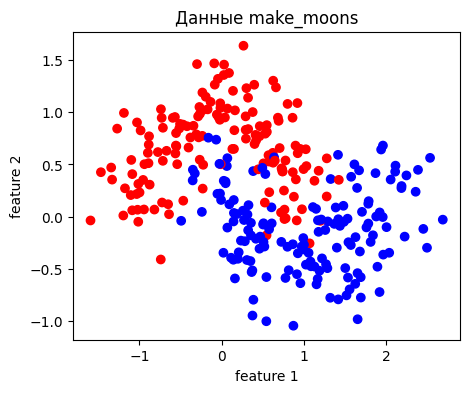

In [7]:
# Данные make_moons
X_moons, y_moons = make_moons(
    n_samples=300,
    noise=0.25,
    random_state=42
)

plt.figure(figsize=(5, 4))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=ListedColormap(["#FF0000", "#0000FF"]))
plt.title("Данные make_moons")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.show()

Лучшие гиперпараметры: {'svc__C': 1.0, 'svc__gamma': 10.0}
Лучший средний accuracy на CV: 0.9000000000000001
Accuracy на отложенном тесте: 0.9222222222222223


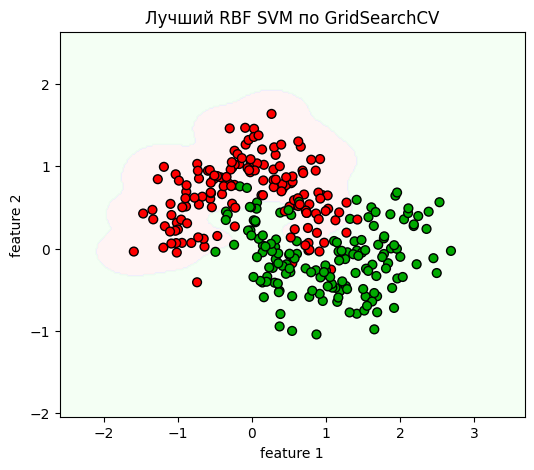

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=42, stratify=y_moons
)

pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf"))
])

param_grid = {
    "svc__C": [0.1, 1.0, 10.0, 100.0],
    "svc__gamma": [0.1, 1.0, 10.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Лучшие гиперпараметры:", grid.best_params_)
print("Лучший средний accuracy на CV:", grid.best_score_)

best_model = grid.best_estimator_

# Оценка на тестовой выборке
y_test_pred = best_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
print("Accuracy на отложенном тесте:", test_acc)

plot_decision_boundary(best_model, X_moons, y_moons, title="Лучший RBF SVM по GridSearchCV")

Заметим важные моменты:

- масштабирование признаков (`StandardScaler`) включено в `Pipeline`, а `GridSearchCV` получает на вход именно пайплайн;
- перебор $C$ и $\gamma$ происходит внутри кросс-валидации на обучающей части;
- отложенный тест `X_test, y_test` используется **один раз** для финальной оценки качества уже после выбора гиперпараметров.


## 6. `RandomizedSearchCV`: случайный поиск по гиперпараметрам

`GridSearchCV` перебирает **все** комбинации из заданной сетки. Это может быть дорого, если:

- гиперпараметров много;
- у каждого гиперпараметра длинный список возможных значений.

`RandomizedSearchCV` вместо этого выбирает **случайные комбинации** из пространства гиперпараметров.

Преимущества:

- можно ограничить число итераций `n_iter`;
- при хорошем выборе диапазонов часто можно найти "неплохие" гиперпараметры дешевле, чем полным перебором.

Рассмотрим пример с `RandomForestClassifier`.


In [9]:
rf = RandomForestClassifier(random_state=42)

pipe_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", rf)
])

param_distributions = {
    "rf__n_estimators": [50, 100, 150, 200],
    "rf__max_depth": [3, 5, 7, 9, None],
    "rf__max_features": ["sqrt", "log2", None]
}

rand_search = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_distributions,
    n_iter=10,
    cv=cv,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

rand_search.fit(X_train, y_train)

print("Лучшие гиперпараметры (RandomizedSearchCV):", rand_search.best_params_)
print("Лучший средний accuracy на CV:", rand_search.best_score_)

best_rf = rand_search.best_estimator_
y_test_pred_rf = best_rf.predict(X_test)
print("Accuracy RandomForest на тесте:", accuracy_score(y_test, y_test_pred_rf))

Лучшие гиперпараметры (RandomizedSearchCV): {'rf__n_estimators': 150, 'rf__max_features': 'log2', 'rf__max_depth': None}
Лучший средний accuracy на CV: 0.9095238095238095
Accuracy RandomForest на тесте: 0.9333333333333333


На практике:

- `GridSearchCV` удобно использовать для небольшой сетки важнейших гиперпараметров;
- `RandomizedSearchCV` — когда пространство гиперпараметров большое, и мы хотим ограничить число попыток разумным `n_iter`.


## 7. Вложенная кросс-валидация (nested cross-validation)

Проблема: когда мы подбираем гиперпараметры по результатам кросс-валидации, а потом берём **тот же самый CV-score** (лучший), он становится **смещённой оценкой** качества (мы оптимизировали по нему).

Если нам нужна максимально честная оценка качества модели **с учётом выбора гиперпараметров**, используют **вложенную кросс-валидацию**:

- внешний цикл (outer CV) — делит данные на train и test для оценки;
- на каждом внешнем train мы запускаем внутренний `GridSearchCV` или `RandomizedSearchCV` (inner CV) для подбора гиперпараметров;
- итоговая оценка — среднее качество по внешним фолдам.

Схематично:

1. Внешний $K$-fold:
   - на каждом фолде внешний train + внешний validation.
2. На внешнем train запускаем перебор гиперпараметров с кросс-валидацией (внутренний CV).
3. Выбранную на внутреннем CV модель тестируем на внешнем validation.
4. Усредняем качество по внешним фолдам.

В `scikit-learn` это можно реализовать так: использовать `GridSearchCV` как оценщик внутри `cross_val_score`.


In [10]:
# Пример кода (может быть дорогим по времени на реальных данных)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

pipe_svm_nested = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf"))
])

param_grid_nested = {
    "svc__C": [0.1, 1.0, 10.0],
    "svc__gamma": [0.1, 1.0, 10.0]
}

inner_search = GridSearchCV(
    estimator=pipe_svm_nested,
    param_grid=param_grid_nested,
    cv=inner_cv,
    scoring="accuracy",
    n_jobs=-1
)

nested_scores = cross_val_score(
    inner_search,
    X_moons,
    y_moons,
    cv=outer_cv,
    scoring="accuracy"
)

print("Оценки accuracy по внешним фолдам (nested CV):", nested_scores)
print("Средний nested CV accuracy:", nested_scores.mean())

Оценки accuracy по внешним фолдам (nested CV): [0.85 0.92 0.92]
Средний nested CV accuracy: 0.8966666666666666


Вложенная кросс-валидация даёт более честную оценку качества **процесса** "модель + подбор гиперпараметров", но она существенно дороже вычислительно. В учебных примерах достаточно понимать идею и базовый код.


## 8. Байесовская оптимизация и Optuna (концептуально)

`GridSearchCV` и `RandomizedSearchCV` перебирают гиперпараметры "вслепую":

- grid search — все комбинации из сетки;
- randomized search — случайные комбинации.

Если гиперпараметров много и обучение модели дорого, такой поиск может быть неэффективен. Современный подход — **байесовская оптимизация**, когда:

- мы строим аппроксимацию зависимости метрики (например, accuracy) от гиперпараметров;
- выбираем новые точки для проверки, исходя из уже полученных результатов (exploration vs exploitation).

Одним из популярных инструментов для такого поиска является библиотека **Optuna**.

Cм. ноутбук AutoML

Идея: Optuna сама выбирает новые сочетания гиперпараметров на основе уже полученных результатов, что может быть эффективнее, чем перебор по сетке или чисто случайный поиск.


## 9. Сериализация моделей: сохранение и загрузка

После того как мы обучили модель и подобрали гиперпараметры, типичный следующий шаг — **сохранить модель в файл**, чтобы:

- использовать её в другом скрипте или сервисе (инференс);
- не переобучать модель каждый раз заново;
- передать модель коллегам.

В `scikit-learn` стандартный способ — использовать библиотеку `joblib`:

- `joblib.dump(obj, filename)` — сохранит объект в файл;
- `joblib.load(filename)` — загрузит объект обратно.

Важно:

- сохранять имеет смысл **весь пайплайн** (включая масштабирование признаков, кодирование категориальных признаков и т.п.);
- нужно следить за версиями библиотек: модель, сохранённая в одной версии `scikit-learn`, может не всегда загружаться в сильно другой версии.


### 9.1. Сохранение лучшей модели после GridSearchCV

Продолжим пример с SVM и `GridSearchCV`. Мы уже получили `best_model` — это лучший пайплайн `StandardScaler + SVC`. Сохраним его и проверим, что после загрузки он работает так же.


In [12]:
import joblib

# Сохранение лучшей модели в файл
joblib.dump(best_model, "best_svm_moons.joblib")

['best_svm_moons.joblib']

In [15]:
# Загрузка модели из файла
loaded_model = joblib.load("best_svm_moons.joblib")

print(type(loaded_model))

# Проверим, что качество на тесте совпадает
y_test_pred_loaded = loaded_model.predict(X_test)
print("Accuracy загруженной модели на тесте:", accuracy_score(y_test, y_test_pred_loaded))

<class 'sklearn.pipeline.Pipeline'>
Accuracy загруженной модели на тесте: 0.9222222222222223


Обычно в продакшене:

- обучающая часть (подбор гиперпараметров, кросс-валидация) живёт в одном скрипте или ноутбуке;
- итоговый пайплайн сериализуется в файл;
- сервис для инференса просто загружает этот пайплайн и применяет метод `predict` к новым данным.


## 10. Итоги и практические рекомендации

В этом ноутбуке мы рассмотрели:

- ограничения простого train/test split и мотивацию для кросс-валидации;
- $K$-fold и стратифицированную кросс-валидацию, функции `cross_val_score` и `cross_validate`;
- другие схемы разбиения, включая `TimeSeriesSplit` для временных рядов;
- перебор гиперпараметров как задачу оптимизации по сетке значений;
- использование `GridSearchCV` для полного перебора и `RandomizedSearchCV` для случайного поиска;
- идею вложенной кросс-валидации для честной оценки качества с учётом подбора гиперпараметров;
- концепцию байесовской оптимизации и библиотеку Optuna (на уровне примера кода);
- сериализацию моделей с помощью `joblib`, включая сохранение всего пайплайна.

Практические советы:

1. **Всегда отделяйте тестовый набор** и используйте его только для финальной оценки, после выбора гиперпараметров.
2. **Используйте пайплайны**: масштабирование, кодирование и модель должны быть объединены в один объект, чтобы кросс-валидация и инференс были корректными.
3. **Подбирайте гиперпараметры с кросс-валидацией** (`GridSearchCV`, `RandomizedSearchCV`), особенно на небольших и средних выборках.
4. **Для больших и дорогих моделей** рассматривайте более умные методы оптимизации гиперпараметров (Optuna, байесовская оптимизация).
5. **Сохраняйте обученные модели** (`joblib.dump`) и загружайте их для инференса (`joblib.load`), не переобучая лишний раз.

Эти техники используются практически во всех реальных проектах классического машинного обучения и являются обязательной частью практического пайплайна.
